# __<font size="6">Introduction</font>__

New York City is the largest city in the United States of America with a population of nearly 8.5 million as of 2018. New York City is historically a melting pot of cultures, 
people and food as it has been the biggest gateway of immigration into the United States over the history of the nation. 

Having said that, this project explores where the best places to open an Italian restaurant in New York City are. Factors such as the borough, neighborhood and nearby competition are all taken into account as we try to answer the question of where is the best place to open an Italian restaurant in New York City?

# __<font size="5">Business Problem</font>__

The objective of this project is to analyze and find the best areas of New York City to open a new Italian restaurant. I use Data Science methodology in addition to Data Analysis and Data Visualization to answer the question: Where is the best place to open a new Italian restaurant in New York City?

# __<font size="5">Target Audience</font>__

The target audience of this project is real estate developers and investors who might be interested in opening an Italian restaurant in the largest and one of the most diverse cities in the US. Obviously, restaurants and the food market in general in New York is crowded so I want to help pinpoint the best opportunities for potential developers/investors.

# __<font size=5>Data Used<font/>__

__To solve our problem, we need this data:__

   - NYC data containing both neighborhoods and boroughs.

   - Latitude and longitude data of neighborhoods so we can plot them.

- Venue and restaurant data to perform analysis of opportunity and competition in specific neighborhoods.

# __<font size="6">Data Sources</font>__

We use the open data source https://cocl.us/new_york_dataset for the neighborhoods and boroughs data needed for this project. We'll use the Python Geocoder package to obtain the latitude and longitude of the neighborhoods. <br>
<br>
We will then use the Foursquare API to get the venue data for the neighborhoods. With over 105 million places, the Foursquare API has one of the largest databases on the internet. Foursquare has many categories of venue data but we are particularly interested in the restaurant data as it will be key to solving our problem. Lastly,we will use Folium for data visualization.

# __<font size="6">Importing Required Libraries</font>__

In [4]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
import requests

from bs4 import BeautifulSoup
import os

In [7]:
!pip install folium==0.5.0
import folium

print('Folium installed and imported!')

Folium installed and imported!


In [8]:
from geopy.geocoders import Nominatim
import requests

In [9]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


# __<font size=6>Foursqaure Credentials<font/>__

In [10]:
CLIENT_ID = 'PA3LK3NQ3PCOPO1AS5LUDKQXRBUYW2GPUYB2EBOR1XCUHWWE' # your Foursquare ID
CLIENT_SECRET = 'H30DLTDNTK01P2Z44I4LMZRRQ0NK1AJ24AP42IXC1JBJTODC' # your Foursquare Secret
VERSION = '20201020'

# __<font size=6>Define Functions<font/>__

In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=250
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [12]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
ny_data.shape

(306, 4)

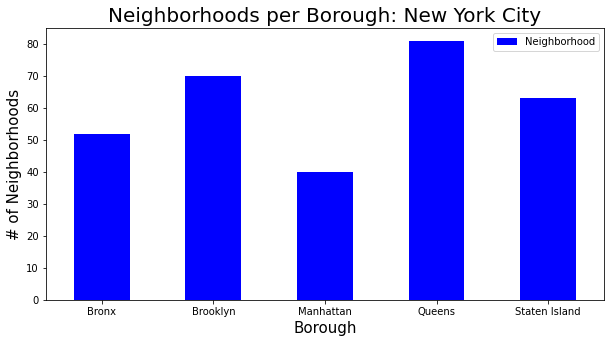

In [14]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('# of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    print(row)
    for resturant_detail in italian_restaurants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
['

( 68 / 306 ) Italian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Italian Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Italian Restaurants in Fort Greene, Brooklyn:3
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Italian Restaurants in Park Slope, Brooklyn:2
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Italian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Italian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Italian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Italian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Italian Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Italian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Italian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Italian Restaurants in Howard Beach, Queens:3
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Italian Restaurants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Italian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Italian Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Italian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) I

( 198 / 306 ) Italian Restaurants in St. George, Staten Island:2
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Italian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Italian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Italian Restaurants in Rosebank, Staten Island:1
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Italian Restaurants in West Brighton, Staten Island:2
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Italian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Italian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Italian Restaurants in South Bea

( 260 / 306 ) Italian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Italian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Italian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Italian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Italian Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Italian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Italian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Italian Restaurants in Astoria Heights, Queens:1
['Queens', 'Astoria Heights', 40.7703173929982, -73.894679962

In [20]:
# Save the infor to a .csv file due to limited calls on FourSquare
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv')

In [17]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
225,225,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta
226,226,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa
227,227,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
228,228,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
229,229,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [18]:
italian_rest_ny.shape

(230, 5)

This shows there are 230 Italian restaurants across New York City.

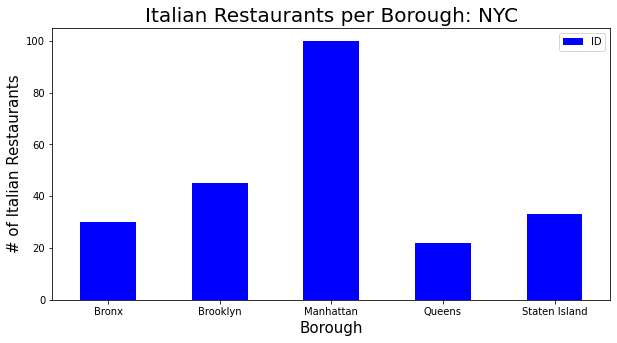

In [19]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('# of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

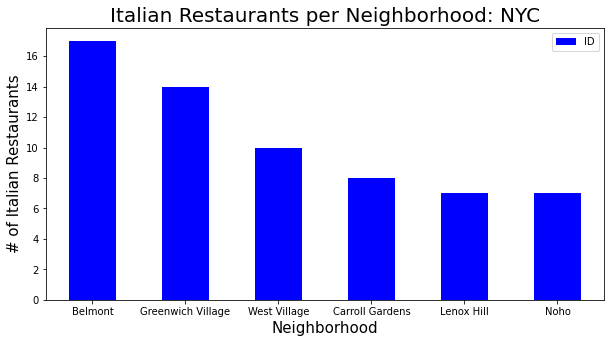

In [20]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('# of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

As we can see from these plots, Manahttan has the highest number of Italian restaurants of any borough in New York City with nearly 100. The neighborhood with the highest number of Italian restaurants in the city is not actually in Manhattan, but in the Bronx. The Belmont neighborhood in the Bronx has 17 Italian restaurants living up to its reputation as "Brooklyn's Little Italy".

In [21]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Unnamed: 0,Borough,Neighborhood,ID,Name
6,6,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
7,7,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
8,8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,9,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
10,10,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
11,11,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
12,12,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
13,13,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
14,14,Bronx,Belmont,4bc22a22920eb713bcc51b2c,Tra Di Noi
15,15,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's


In [28]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f8f46b82be1a37c2804dad5'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5f8f46b8524ab44c020d1bf0'}, 'response': {'venue': {'id': '4b47f069f964a5208c4426e3', 'name': 'Pasta Pasta', 'contact': {'phone': '7188929634', 'formattedPhone': '(718) 892-9634'}, 'location': {'address': '2023 Williamsbridge Rd', 'lat': 40.85478806485715, 'lng': -73.85492881053774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85478806485715, 'lng': -73.85492881053774}, {'label': 'entrance', 'lat': 40.854792, 'lng': -73.855184}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2023 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasta-pasta/4b47f069f964a5208c4426e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5f8f46b9c061ad307c971874'}, 'response': {'venue': {'id': '4514ed4df964a520e5391fe3', 'name': "Artie's Steak and Seafood", 'contact': {'phone': '7188859885', 'formattedPhone': '(718) 885-9885', 'twitter': 'artiescrazy'}, 'location': {'address': '394 City Island Ave', 'lat': 40.849542144998146, 'lng': -73.78731730033616, 'labeledLatLngs': [{'label': 'display', 'lat': 40.849542144998146, 'lng': -73.78731730033616}, {'label': 'entrance', 'lat': 40.849596, 'lng': -73.787218}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arties-steak-and-seafood/4514ed4df964a520e5391fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',

{'meta': {'code': 200, 'requestId': '5f8f46b956c1c62a0943b8dd'}, 'response': {'venue': {'id': '4b10591af964a5205f6e23e3', 'name': "Patricia's", 'contact': {'phone': '7184099069', 'formattedPhone': '(718) 409-9069', 'twitter': 'patriciasnyc'}, 'location': {'address': '1082 Morris Park Ave', 'lat': 40.84931298339339, 'lng': -73.85353576737785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84931298339339, 'lng': -73.85353576737785}, {'label': 'entrance', 'lat': 40.849229, 'lng': -73.853395}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1082 Morris Park Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patricias/4b10591af964a5205f6e23e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5f8f46b9960f157f91425c3b'}, 'response': {'venue': {'id': '4af71916f964a520cf0522e3', 'name': "Michaelangelo's Coal Fired Brick Oven Pizza Restaurant", 'contact': {'phone': '3475907650', 'formattedPhone': '(347) 590-7650'}, 'location': {'address': '2477 Arthur Ave', 'lat': 40.85741189614754, 'lng': -73.88646821282298, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85741189614754, 'lng': -73.88646821282298}, {'label': 'entrance', 'lat': 40.857301, 'lng': -73.886231}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2477 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michaelangelos-coal-fired-brick-oven-pizza-restaurant/4af71916f964a520cf0522e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

{'meta': {'code': 200, 'requestId': '5f8f46baa106903c94340210'}, 'response': {'venue': {'id': '4bb6470cef159c7465b275f7', 'name': 'Calabria Pork Store', 'contact': {'phone': '7183675145', 'formattedPhone': '(718) 367-5145'}, 'location': {'address': '2338 Arthur Ave', 'lat': 40.85414529023418, 'lng': -73.88877606219484, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85414529023418, 'lng': -73.88877606219484}, {'label': 'entrance', 'lat': 40.854096, 'lng': -73.888659}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2338 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/calabria-pork-store/4bb6470cef159c7465b275f7', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4

{'meta': {'code': 200, 'requestId': '5f8f46ba56c1c62a0943bcbe'}, 'response': {'venue': {'id': '4b5a4c8ff964a52049bb28e3', 'name': "Emilia's Restaurant", 'contact': {'phone': '7183675915', 'formattedPhone': '(718) 367-5915'}, 'location': {'address': '2331 Arthur Ave', 'lat': 40.85412010500031, 'lng': -73.88890998498077, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85412010500031, 'lng': -73.88890998498077}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2331 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emilias-restaurant/4b5a4c8ff964a52049bb28e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'url': 'http://emiliasr

{'meta': {'code': 200, 'requestId': '5f8f46bb9d7cfa6c1bc7030d'}, 'response': {'venue': {'id': '4aa425bef964a5208e4520e3', 'name': "Dominick's Restaurant", 'contact': {'phone': '7187332807', 'formattedPhone': '(718) 733-2807', 'twitter': 'dominicksrest'}, 'location': {'address': '2335 Arthur Ave', 'lat': 40.85421506482662, 'lng': -73.88876521498301, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85421506482662, 'lng': -73.88876521498301}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.888834}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2335 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominicks-restaurant/4aa425bef964a5208e4520e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5f8f46bb90fd6244ffc223d8'}, 'response': {'venue': {'id': '4af0fa29f964a52060e021e3', 'name': "Antonio's Trattoria", 'contact': {'phone': '7187336630', 'formattedPhone': '(718) 733-6630'}, 'location': {'address': '2370 Belmont Ave', 'lat': 40.854082862115455, 'lng': -73.88661644989108, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854082862115455, 'lng': -73.88661644989108}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.886599}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2370 Belmont Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/antonios-trattoria/4af0fa29f964a52060e021e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5f8f46bbbd28c54ba2b2301e'}, 'response': {'venue': {'id': '4b5514c4f964a5207cda27e3', 'name': "Enzo's", 'contact': {'phone': '7187334455', 'formattedPhone': '(718) 733-4455'}, 'location': {'address': '2339 Arthur Ave', 'lat': 40.854354554251444, 'lng': -73.88864359312625, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854354554251444, 'lng': -73.88864359312625}, {'label': 'entrance', 'lat': 40.854339, 'lng': -73.888759}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2339 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/enzos/4b5514c4f964a5207cda27e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '5f8f46bc418d9541e7ff1e84'}, 'response': {'venue': {'id': '4c79d294278eb713f6a05580', 'name': 'Cafe al Mercato', 'contact': {'phone': '7183647681', 'formattedPhone': '(718) 364-7681'}, 'location': {'address': '2344 Arthur Ave', 'lat': 40.85417649340613, 'lng': -73.88808455700543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85417649340613, 'lng': -73.88808455700543}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2344 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-al-mercato/4c79d294278eb713f6a05580', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message':

{'meta': {'code': 200, 'requestId': '5f8f46bc465445080889b733'}, 'response': {'venue': {'id': '4cb0d382ef1b370419643e00', 'name': "David Greco's Arthur Avenue Trattoria", 'contact': {}, 'location': {'lat': 40.854031511759736, 'lng': -73.88887832314941, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854031511759736, 'lng': -73.88887832314941}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/david-grecos-arthur-avenue-trattoria/4cb0d382ef1b370419643e00', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 6, 'groups'

{'meta': {'code': 200, 'requestId': '5f8f46bc524ab44c020d2b3a'}, 'response': {'venue': {'id': '4bc67f1104e8b713a833362d', 'name': "Ann & Tony's - An Original Arthur Avenue Restaurant", 'contact': {'phone': '7189331469', 'formattedPhone': '(718) 933-1469', 'twitter': 'annandtonys'}, 'location': {'address': '2407 Arthur Ave', 'crossStreet': 'at E.187th Street', 'lat': 40.855704465427415, 'lng': -73.88744918407676, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855704465427415, 'lng': -73.88744918407676}, {'label': 'entrance', 'lat': 40.855798, 'lng': -73.88751}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2407 Arthur Ave (at E.187th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ann--tonys--an-original-arthur-avenue-restaurant/4bc67f1104e8b713a833362d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', '

{'meta': {'code': 200, 'requestId': '5f8f46bdad784013df41c900'}, 'response': {'venue': {'id': '4b3bdd2cf964a520f57c25e3', 'name': "Madison's", 'contact': {}, 'location': {'address': '5686 Riverdale Ave', 'lat': 40.90648305752465, 'lng': -73.90396530525271, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90648305752465, 'lng': -73.90396530525271}, {'label': 'entrance', 'lat': 40.906494, 'lng': -73.904016}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5686 Riverdale Ave', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/madisons/4b3bdd2cf964a520f57c25e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c0941735', 'name': 'Mediterranean Restaurant', 'pluralNam

{'meta': {'code': 200, 'requestId': '5f8f46bdb3c24f7b3858a29e'}, 'response': {'venue': {'id': '4c9e1ef2542b224b70a3f09f', 'name': 'Lucca Italian Restaurant', 'contact': {'phone': '7188928282', 'formattedPhone': '(718) 892-8282'}, 'location': {'address': '3019 Westchester Ave', 'crossStreet': 'Hobart Ave', 'lat': 40.847676, 'lng': -73.831834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.847676, 'lng': -73.831834}, {'label': 'entrance', 'lat': 40.84769, 'lng': -73.831699}], 'postalCode': '10461', 'cc': 'US', 'neighborhood': 'Pelham Bay', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3019 Westchester Ave (Hobart Ave)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucca-italian-restaurant/4c9e1ef2542b224b70a3f09f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5f8f46bd0bf98854155689fa'}, 'response': {'venue': {'id': '4c9518076b35a143d5dc21dc', 'name': "Fratelli's", 'contact': {'phone': '7185472489', 'formattedPhone': '(718) 547-2489'}, 'location': {'address': '2507 Eastchester Rd', 'lat': 40.86301897888721, 'lng': -73.84360740712835, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86301897888721, 'lng': -73.84360740712835}, {'label': 'entrance', 'lat': 40.863085, 'lng': -73.8436}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2507 Eastchester Rd', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fratellis/4c9518076b35a143d5dc21dc', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '5f8f46beedf6b74902cb6034'}, 'response': {'venue': {'id': '4b70d8dff964a52063312de3', 'name': 'Tuscany Grill', 'contact': {'phone': '7189215633', 'formattedPhone': '(718) 921-5633'}, 'location': {'address': '8620 3rd Ave', 'lat': 40.62291326029698, 'lng': -74.03138652017468, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62291326029698, 'lng': -74.03138652017468}, {'label': 'entrance', 'lat': 40.622918, 'lng': -74.031438}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8620 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tuscany-grill/4b70d8dff964a52063312de3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 's

{'meta': {'code': 200, 'requestId': '5f8f46bedd96685c64aa75c2'}, 'response': {'venue': {'id': '4ad62c95f964a5208d0521e3', 'name': 'Zio Toto', 'contact': {'phone': '7182388042', 'formattedPhone': '(718) 238-8042'}, 'location': {'address': '8407 3rd Ave', 'crossStreet': 'btwn 84th & 85th St', 'lat': 40.62479085034183, 'lng': -74.03055087900958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62479085034183, 'lng': -74.03055087900958}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8407 3rd Ave (btwn 84th & 85th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zio-toto/4ad62c95f964a5208d0521e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '5f8f46bedc3fa014e61e7d6a'}, 'response': {'venue': {'id': '4e732dff45dd41e9ccce1987', 'name': "Giacomo's Wood Fired Pizza & Trattoria", 'contact': {'phone': '7184396993', 'formattedPhone': '(718) 439-6993'}, 'location': {'address': '7902 3rd Ave', 'lat': 40.62853486510589, 'lng': -74.02905124266296, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62853486510589, 'lng': -74.02905124266296}, {'label': 'entrance', 'lat': 40.628483, 'lng': -74.029154}], 'postalCode': '11209', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7902 3rd Ave', 'Staten Island, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giacomos-wood-fired-pizza--trattoria/4e732dff45dd41e9ccce1987', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 

{'meta': {'code': 200, 'requestId': '5f8f46be50a2d03ad569556b'}, 'response': {'venue': {'id': '5ce87094c4df1d002c9e1564', 'name': 'Baci', 'contact': {}, 'location': {'lat': 40.624347, 'lng': -74.030761, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624347, 'lng': -74.030761}], 'postalCode': '11209', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baci/5ce87094c4df1d002c9e1564', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'delivery': {'id': '2216654', 'url': 'https://www.seaml

{'meta': {'code': 200, 'requestId': '5f8f46bf524ab44c020d33fb'}, 'response': {'venue': {'id': '4ae23a80f964a5200c8c21e3', 'name': 'il Colosseo', 'contact': {'phone': '7182343663', 'formattedPhone': '(718) 234-3663', 'twitter': 'il_colosseo'}, 'location': {'address': '7704 18th Ave', 'lat': 40.61222053559676, 'lng': -73.9974361996248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61222053559676, 'lng': -73.9974361996248}, {'label': 'entrance', 'lat': 40.612153, 'lng': -73.997409}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7704 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/il-colosseo/4ae23a80f964a5200c8c21e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5f8f46bfb3c24f7b3858ab2c'}, 'response': {'venue': {'id': '4ff37cb9e4b0b8fda883be7f', 'name': "Adelina's", 'contact': {'phone': '3477630152', 'formattedPhone': '(347) 763-0152', 'twitter': 'adelinas_wine', 'facebook': '348757038525931', 'facebookUsername': 'AdelinasBK', 'facebookName': "Adelina's"}, 'location': {'address': '159 Greenpoint Ave', 'crossStreet': 'at Leonard St.', 'lat': 40.730301301138475, 'lng': -73.95335193287592, 'labeledLatLngs': [{'label': 'display', 'lat': 40.730301301138475, 'lng': -73.95335193287592}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159 Greenpoint Ave (at Leonard St.)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/adelinas_wine', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5f8f46c0c061ad307c9731c2'}, 'response': {'venue': {'id': '5a98aed16a59506d7a60d67c', 'name': 'Carmenta’s', 'contact': {'phone': '7186765003', 'formattedPhone': '(718) 676-5003'}, 'location': {'address': '50 Starr St', 'crossStreet': 'Wilson Ave', 'lat': 40.701320324636875, 'lng': -73.92678265951356, 'labeledLatLngs': [{'label': 'display', 'lat': 40.701320324636875, 'lng': -73.92678265951356}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['50 Starr St (Wilson Ave)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/carmentas/5a98aed16a59506d7a60d67c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21},

{'meta': {'code': 200, 'requestId': '5f8f46c0b530f203329cd1dd'}, 'response': {'venue': {'id': '5e4567fa2eafa100085e9ec3', 'name': 'Bar Camillo', 'contact': {'phone': '3475336340', 'formattedPhone': '(347) 533-6340', 'instagram': 'barcamillobk'}, 'location': {'address': '333 Tompkins Ave', 'lat': 40.686523, 'lng': -73.944379, 'labeledLatLngs': [{'label': 'display', 'lat': 40.686523, 'lng': -73.944379}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Tompkins Ave', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bar-camillo/5e4567fa2eafa100085e9ec3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://barcamillo.com', 'p

{'meta': {'code': 200, 'requestId': '5f8f46c0960f157f9142742d'}, 'response': {'venue': {'id': '3fd66200f964a52011f11ee3', 'name': 'Caffe Buon Gusto', 'contact': {'phone': '7186243838', 'formattedPhone': '(718) 624-3838'}, 'location': {'address': '151 Montague St', 'lat': 40.69461587788547, 'lng': -73.99338165894984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69461587788547, 'lng': -73.99338165894984}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Montague St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-buon-gusto/3fd66200f964a52011f11ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 19}, 'url': 'http://www.caff

{'meta': {'code': 200, 'requestId': '5f8f46c0418d9541e7ff2fb6'}, 'response': {'venue': {'id': '5a0740a3e1f22816d11723d5', 'name': 'Lillo', 'contact': {'phone': '3477630899', 'formattedPhone': '(347) 763-0899'}, 'location': {'address': '331 Henry Street', 'lat': 40.690199941477445, 'lng': -73.99654010450837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.690199941477445, 'lng': -73.99654010450837}], 'postalCode': '11201', 'cc': 'US', 'neighborhood': 'Cobble Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['331 Henry Street', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lillo/5a0740a3e1f22816d11723d5', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '5f8f46c1c061ad307c973613'}, 'response': {'venue': {'id': '5044f749e4b0dd909d2cc123', 'name': 'Table 87', 'contact': {'phone': '7187979300', 'formattedPhone': '(718) 797-9300'}, 'location': {'address': '87 Atlantic Ave', 'lat': 40.69116378701994, 'lng': -73.99744297710961, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69116378701994, 'lng': -73.99744297710961}, {'label': 'entrance', 'lat': 40.691219, 'lng': -73.997355}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87 Atlantic Ave', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/table-87/5044f749e4b0dd909d2cc123', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c

{'meta': {'code': 200, 'requestId': '5f8f46c1c061ad307c973773'}, 'response': {'venue': {'id': '4aa85f31f964a520075120e3', 'name': "Vinny's of Carroll Gardens", 'contact': {'phone': '7188755600', 'formattedPhone': '(718) 875-5600'}, 'location': {'address': '295 Smith St', 'crossStreet': 'Btw. Union & Sacket', 'lat': 40.681885, 'lng': -73.99357, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681885, 'lng': -73.99357}, {'label': 'entrance', 'lat': 40.681897, 'lng': -73.993624}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['295 Smith St (Btw. Union & Sacket)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vinnys-of-carroll-gardens/4aa85f31f964a520075120e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix

{'meta': {'code': 200, 'requestId': '5f8f46c1223d4b1cdd793825'}, 'response': {'venue': {'id': '5766ad56498ebf269c3737d2', 'name': 'Gersi', 'contact': {'phone': '3478895077', 'formattedPhone': '(347) 889-5077', 'twitter': 'gersirestaurant'}, 'location': {'address': '316 Court St', 'crossStreet': 'Sackett Street', 'lat': 40.68337949868895, 'lng': -73.99549228030504, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68337949868895, 'lng': -73.99549228030504}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['316 Court St (Sackett Street)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gersi/5766ad56498ebf269c3737d2', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5f8f46c2a97868185a3cc2b6'}, 'response': {'venue': {'id': '5001e284e4b0d8ae060e1035', 'name': 'Ciros on Smith', 'contact': {}, 'location': {'address': '307 Smith St', 'crossStreet': 'Union', 'lat': 40.68148804379713, 'lng': -73.99402221751436, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68148804379713, 'lng': -73.99402221751436}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['307 Smith St (Union)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ciros-on-smith/5001e284e4b0d8ae060e1035', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '

{'meta': {'code': 200, 'requestId': '5f8f46c2561497763b2f9b71'}, 'response': {'venue': {'id': '4ab98ab8f964a520cf7f20e3', 'name': 'Marco Polo Ristorante', 'contact': {'phone': '7188525015', 'formattedPhone': '(718) 852-5015', 'twitter': 'marcopolorist'}, 'location': {'address': '345 Court St', 'crossStreet': 'at Union St', 'lat': 40.68231096732147, 'lng': -73.99591141723491, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68231096732147, 'lng': -73.99591141723491}, {'label': 'entrance', 'lat': 40.682241, 'lng': -73.995809}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['345 Court St (at Union St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marco-polo-ristorante/4ab98ab8f964a520cf7f20e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/

{'meta': {'code': 200, 'requestId': '5f8f46c2c061ad307c973c1f'}, 'response': {'venue': {'id': '5a00f3538496ca58fd9e2856', 'name': 'Evelina Restaurant', 'contact': {'phone': '9292980209', 'formattedPhone': '(929) 298-0209'}, 'location': {'address': '211 Dekalb Ave', 'crossStreet': 'Adelphi', 'lat': 40.689629, 'lng': -73.971018, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689629, 'lng': -73.971018}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['211 Dekalb Ave (Adelphi)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/evelina-restaurant/5a00f3538496ca58fd9e2856', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 34}, 'url': 'http://e

{'meta': {'code': 200, 'requestId': '5f8f46c30572497850abfc26'}, 'response': {'venue': {'id': '4afca48af964a520ab2422e3', 'name': 'Roman’s', 'contact': {'phone': '7186225300', 'formattedPhone': '(718) 622-5300'}, 'location': {'address': '243 Dekalb Ave', 'crossStreet': 'at Vanderbilt Ave.', 'lat': 40.68952914963263, 'lng': -73.96951802846388, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68952914963263, 'lng': -73.96951802846388}, {'label': 'entrance', 'lat': 40.689576, 'lng': -73.96954}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['243 Dekalb Ave (at Vanderbilt Ave.)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/romans/4afca48af964a520ab2422e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': 

{'meta': {'code': 200, 'requestId': '5f8f46c356c1c62a0943dec6'}, 'response': {'venue': {'id': '4a482531f964a5209aaa1fe3', 'name': 'Scottadito Osteria Toscana', 'contact': {'phone': '7186364800', 'formattedPhone': '(718) 636-4800', 'twitter': 'scottadito', 'facebook': '131597613525680', 'facebookUsername': 'ScottaditoOsteriaToscana', 'facebookName': 'Scottadito Osteria Toscana'}, 'location': {'address': '788 Union St', 'crossStreet': 'at 7th Ave.', 'lat': 40.674841377650885, 'lng': -73.97649751739819, 'labeledLatLngs': [{'label': 'display', 'lat': 40.674841377650885, 'lng': -73.97649751739819}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['788 Union St (at 7th Ave.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/scottadito-osteria-toscana/4a482531f964a5209aaa1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restauran

{'meta': {'code': 200, 'requestId': '5f8f46c4b530f203329ce057'}, 'response': {'venue': {'id': '521a7e8a498e9a3defc15591', 'name': 'Casa Edesia Pizza and Grill', 'contact': {'phone': '7185522301', 'formattedPhone': '(718) 552-2301', 'twitter': 'casaedesia'}, 'location': {'address': '2006 Cropsey Ave', 'crossStreet': '20th Ave.', 'lat': 40.599751, 'lng': -74.002672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.599751, 'lng': -74.002672}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2006 Cropsey Ave (20th Ave.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/casaedesia', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place'

{'meta': {'code': 200, 'requestId': '5f8f46c674cc40265e148705'}, 'response': {'venue': {'id': '57240d9b498e96aa8f33acb6', 'name': "Annabelle's", 'contact': {}, 'location': {'lat': 40.61867, 'lng': -74.021635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61867, 'lng': -74.021635}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/annabelles/57240d9b498e96aa8f33acb6', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 6, 'groups': [{'type': 'others', 'count': 6, 'items': [{'id': '383549507', 'firstName': 'Antonietta', 'lastName': 'C', 'ph

{'meta': {'code': 200, 'requestId': '5f8f46c6c3056f1e23209e3d'}, 'response': {'venue': {'id': '572d1d41498e2483c3bed970', 'name': 'Da Ciro Brooklyn', 'contact': {}, 'location': {'address': '458 Myrtle Ave', 'lat': 40.69314, 'lng': -73.967176, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69314, 'lng': -73.967176}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['458 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/da-ciro-brooklyn/572d1d41498e2483c3bed970', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 15, 'groups': [{'type': 'others', '

{'meta': {'code': 200, 'requestId': '5f8f46c7395e5f06832954bb'}, 'response': {'venue': {'id': '4a522e5df964a52055b11fe3', 'name': "Luciano's", 'contact': {'phone': '7188556668', 'formattedPhone': '(718) 855-6668', 'facebook': '399513910087639', 'facebookUsername': 'lucianosbrooklynny', 'facebookName': 'Lucianos Brooklyn'}, 'location': {'address': '15 Metrotech Ctr', 'lat': 40.693985660266506, 'lng': -73.98542137408862, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693985660266506, 'lng': -73.98542137408862}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 Metrotech Ctr', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucianos/4a522e5df964a52055b11fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix

{'meta': {'code': 200, 'requestId': '5f8f46c8418d9541e7ff4a56'}, 'response': {'venue': {'id': '59bfcdfb2079551e2b628d20', 'name': 'Camillo', 'contact': {}, 'location': {'address': '1146 Nostrand Ave', 'crossStreet': 'Rutland Rd.', 'lat': 40.65962621054929, 'lng': -73.95056843938069, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65962621054929, 'lng': -73.95056843938069}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1146 Nostrand Ave (Rutland Rd.)', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/camillo/59bfcdfb2079551e2b628d20', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'http://camillobk.com', 'price': {'tier': 

{'meta': {'code': 200, 'requestId': '5f8f46c9c061ad307c9752c5'}, 'response': {'venue': {'id': '525c26bc11d277827d14468f', 'name': 'Campania Coal Fired Pizza', 'contact': {'phone': '3475174868', 'formattedPhone': '(347) 517-4868', 'facebook': '356672951137226', 'facebookName': 'Campania Coal Fired Pizza'}, 'location': {'address': '9824 4th Ave', 'crossStreet': 'btwn 99th St & Marine Ave', 'lat': 40.613465980586724, 'lng': -74.0332371696127, 'labeledLatLngs': [{'label': 'display', 'lat': 40.613465980586724, 'lng': -74.0332371696127}, {'label': 'entrance', 'lat': 40.613558, 'lng': -74.033235}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9824 4th Ave (btwn 99th St & Marine Ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/campania-coal-fired-pizza/525c26bc11d277827d14468f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian

{'meta': {'code': 200, 'requestId': '5f8f46c950a2d03ad5697b23'}, 'response': {'venue': {'id': '55ff210c498ef9c10335dc0b', 'name': 'Positano', 'contact': {}, 'location': {'address': '10018 4th Ave', 'crossStreet': '101st Street', 'lat': 40.612384661710394, 'lng': -74.03405892854195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.612384661710394, 'lng': -74.03405892854195}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10018 4th Ave (101st Street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/positano/55ff210c498ef9c10335dc0b', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 2, 'message': 'Moderate', 'curren

{'meta': {'code': 200, 'requestId': '5f8f46c96efe695f20b17495'}, 'response': {'venue': {'id': '472a027af964a520ea4b1fe3', 'name': 'Bacaro', 'contact': {'phone': '2129415060', 'formattedPhone': '(212) 941-5060'}, 'location': {'address': '136 Division St', 'crossStreet': 'at Ludlow St', 'lat': 40.714467897557796, 'lng': -73.9915893664933, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714467897557796, 'lng': -73.9915893664933}, {'label': 'entrance', 'lat': 40.714525, 'lng': -73.991611}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['136 Division St (at Ludlow St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bacaro/472a027af964a520ea4b1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5f8f46ca0d71e67f1cdb6da7'}, 'response': {'venue': {'id': '4e4e5a94bd4101d0d7a85abe', 'name': 'Pollo El Provocon', 'contact': {'phone': '2127950001', 'formattedPhone': '(212) 795-0001'}, 'location': {'address': '1495 Saint Nicholas Ave', 'lat': 40.851715087890625, 'lng': -73.93257141113281, 'labeledLatLngs': [{'label': 'display', 'lat': 40.851715087890625, 'lng': -73.93257141113281}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1495 Saint Nicholas Ave', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pollo-el-provocon/4e4e5a94bd4101d0d7a85abe', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1be941735', 'name': 'Latin

{'meta': {'code': 200, 'requestId': '5f8f46cbedf6b74902cb904c'}, 'response': {'venue': {'id': '4a22d7f9f964a520977d1fe3', 'name': 'Sant Ambroeus', 'contact': {'phone': '2125702211', 'formattedPhone': '(212) 570-2211', 'twitter': 'sant_ambroeus', 'facebook': '179539995429661', 'facebookUsername': 'SantAmbroeus', 'facebookName': 'Sant Ambroeus'}, 'location': {'address': '1000 Madison Ave', 'crossStreet': 'btwn 77th & 78th St.', 'lat': 40.77532770471081, 'lng': -73.96281878358091, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77532770471081, 'lng': -73.96281878358091}, {'label': 'entrance', 'lat': 40.775403, 'lng': -73.962961}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1000 Madison Ave (btwn 77th & 78th St.)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sant-ambroeus/4a22d7f9f964a520977d1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restauran

{'meta': {'code': 200, 'requestId': '5f8f46cb08bd407f2db1fd62'}, 'response': {'venue': {'id': '4b3bedfaf964a5209e7e25e3', 'name': 'Antonucci', 'contact': {'phone': '2125705100', 'formattedPhone': '(212) 570-5100'}, 'location': {'address': '170 E 81st St', 'crossStreet': '3rd Avenue', 'lat': 40.77571064654, 'lng': -73.95660701282836, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77571064654, 'lng': -73.95660701282836}], 'postalCode': '10028', 'cc': 'US', 'neighborhood': 'Upper East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 E 81st St (3rd Avenue)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/antonucci/4b3bedfaf964a5209e7e25e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fal

{'meta': {'code': 200, 'requestId': '5f8f46cb589bc022c5a92762'}, 'response': {'venue': {'id': '49fcd632f964a520e36e1fe3', 'name': 'Tiramisu', 'contact': {'phone': '2129889780', 'formattedPhone': '(212) 988-9780'}, 'location': {'address': '1410 3rd Ave', 'crossStreet': 'at 80th St.', 'lat': 40.77494597871838, 'lng': -73.95693214362441, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77494597871838, 'lng': -73.95693214362441}, {'label': 'entrance', 'lat': 40.775127, 'lng': -73.956876}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1410 3rd Ave (at 80th St.)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tiramisu/49fcd632f964a520e36e1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f8f46cc06eac44a5f90c1c3'}, 'response': {'venue': {'id': '4b623700f964a520a83c2ae3', 'name': 'Nica Trattoria', 'contact': {'phone': '2124725040', 'formattedPhone': '(212) 472-5040'}, 'location': {'address': '354 E 84th St', 'lat': 40.775688458031425, 'lng': -73.95057000240742, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775688458031425, 'lng': -73.95057000240742}, {'label': 'entrance', 'lat': 40.775588, 'lng': -73.950621}], 'postalCode': '10028', 'cc': 'US', 'neighborhood': 'Yorkville', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['354 E 84th St', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nica-trattoria/4b623700f964a520a83c2ae3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5f8f46cc6e2aa02db44913d1'}, 'response': {'venue': {'id': '4e4078922271a89dd083d07e', 'name': 'Felice 83', 'contact': {'phone': '2122494080', 'formattedPhone': '(212) 249-4080', 'twitter': 'felice_83', 'facebook': '228995607183713', 'facebookUsername': 'Felice.NewYorkCity', 'facebookName': 'Felice Wine Bar & Ristorante'}, 'location': {'address': '1593 1st Ave', 'crossStreet': 'at E 83rd St.', 'lat': 40.77486666568879, 'lng': -73.950868085548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77486666568879, 'lng': -73.950868085548}], 'postalCode': '10028', 'cc': 'US', 'neighborhood': 'Yorkville', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1593 1st Ave (at E 83rd St.)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/felice-83/4e4078922271a89dd083d07e', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortN

{'meta': {'code': 200, 'requestId': '5f8f46cc223d4b1cdd795f71'}, 'response': {'venue': {'id': '4ad52027f964a5200a0221e3', 'name': 'Ginos Pizzeria', 'contact': {'phone': '2127175336', 'formattedPhone': '(212) 717-5336'}, 'location': {'address': '345 E 83rd St', 'crossStreet': 'at 1st Ave', 'lat': 40.775231503163006, 'lng': -73.9513015269503, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775231503163006, 'lng': -73.9513015269503}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['345 E 83rd St (at 1st Ave)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ginos-pizzeria/4ad52027f964a5200a0221e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735', 

{'meta': {'code': 200, 'requestId': '5f8f46cdedf6b74902cb9769'}, 'response': {'venue': {'id': '4b775e32f964a520a6952ee3', 'name': 'Campagnola Restaurant', 'contact': {'phone': '2128611102', 'formattedPhone': '(212) 861-1102', 'twitter': 'campagnolanyc'}, 'location': {'address': '1382 1st Ave', 'crossStreet': 'at E 74th St.', 'lat': 40.76891229915657, 'lng': -73.95526786844196, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76891229915657, 'lng': -73.95526786844196}, {'label': 'entrance', 'lat': 40.768888, 'lng': -73.954996}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1382 1st Ave (at E 74th St.)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/campagnola-restaurant/4b775e32f964a520a6952ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/

{'meta': {'code': 200, 'requestId': '5f8f46cd3f73b97916c8895a'}, 'response': {'venue': {'id': '4b495fb4f964a520a36e26e3', 'name': 'Delizia 73 Ristorante & Pizza', 'contact': {'phone': '2125178888', 'formattedPhone': '(212) 517-8888', 'twitter': 'delizia73', 'facebook': '297453972412', 'facebookUsername': 'delizia73', 'facebookName': 'Delizia 73 Ristorante & Pizza'}, 'location': {'address': '1374 1st Ave', 'crossStreet': 'at E 73rd St', 'lat': 40.76873386522408, 'lng': -73.95533009269842, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76873386522408, 'lng': -73.95533009269842}, {'label': 'entrance', 'lat': 40.768647, 'lng': -73.955177}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1374 1st Ave (at E 73rd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/delizia73', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restau

{'meta': {'code': 200, 'requestId': '5f8f46cd4e36ac59a5ea555b'}, 'response': {'venue': {'id': '4a78f65ef964a520b7e61fe3', 'name': 'Mezzaluna Restaurants', 'contact': {'phone': '2125359600', 'formattedPhone': '(212) 535-9600'}, 'location': {'address': '1295 3rd Ave', 'crossStreet': 'btwn E 74th & E 75th St', 'lat': 40.771352488755774, 'lng': -73.95968198776245, 'labeledLatLngs': [{'label': 'display', 'lat': 40.771352488755774, 'lng': -73.95968198776245}, {'label': 'entrance', 'lat': 40.771192, 'lng': -73.959341}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1295 3rd Ave (btwn E 74th & E 75th St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mezzaluna-restaurants/4a78f65ef964a520b7e61fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5f8f46ce524ab44c020d694a'}, 'response': {'venue': {'id': '547bad25498e5c0b5784c014', 'name': 'Caffe dei Fiori', 'contact': {'phone': '3152581150', 'formattedPhone': '(315) 258-1150', 'facebook': '1640721676182594', 'facebookUsername': 'wearecaffedeifiori', 'facebookName': 'Caffe Dei Fiori'}, 'location': {'address': '973 Lexington Ave', 'crossStreet': 'Between 70th & 71st', 'lat': 40.76940091363795, 'lng': -73.96288348301228, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76940091363795, 'lng': -73.96288348301228}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['973 Lexington Ave (Between 70th & 71st)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-dei-fiori/547bad25498e5c0b5784c014', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'

{'meta': {'code': 200, 'requestId': '5f8f46ceafd98854dd09d170'}, 'response': {'venue': {'id': '56afed04498e39e35747adf2', 'name': 'Pizzeria Sirenetta', 'contact': {'phone': '2127997401', 'formattedPhone': '(212) 799-7401', 'twitter': 'sirenetta_nyc', 'facebook': '1028158793906849', 'facebookUsername': 'sirenettanyc', 'facebookName': 'Pizzeria Sirenetta'}, 'location': {'address': '568 Amsterdam Avenue', 'crossStreet': 'W 87th Street', 'lat': 40.78864019118798, 'lng': -73.9742819869487, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78864019118798, 'lng': -73.9742819869487}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['568 Amsterdam Avenue (W 87th Street)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/sirenetta_nyc', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '5f8f46cea97868185a3cef20'}, 'response': {'venue': {'id': '4c881d60a0ffb60ccda81fc5', 'name': 'Lincoln Ristorante', 'contact': {'phone': '2123596500', 'formattedPhone': '(212) 359-6500', 'twitter': 'lincolnnyc_65th'}, 'location': {'address': '142 W 65th St', 'lat': 40.77341322112094, 'lng': -73.98353503896452, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77341322112094, 'lng': -73.98353503896452}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['142 W 65th St', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lincoln-ristorante/4c881d60a0ffb60ccda81fc5', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d121941735', 'nam

{'meta': {'code': 200, 'requestId': '5f8f46cff0d338172805b762'}, 'response': {'venue': {'id': '5633bec0498e430fc8ba8f3c', 'name': 'La Vela Dining & Bar', 'contact': {}, 'location': {'address': '558 11th Avenue', 'crossStreet': '42nd & 43rd Streets', 'lat': 40.76115612063494, 'lng': -73.9981398392287, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76115612063494, 'lng': -73.9981398392287}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['558 11th Avenue (42nd & 43rd Streets)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-vela-dining--bar/5633bec0498e430fc8ba8f3c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '5f8f46cf8d464035d6c86cba'}, 'response': {'venue': {'id': '4abad7b8f964a520208320e3', 'name': 'Il Punto Ristorante', 'contact': {'phone': '2122440088', 'formattedPhone': '(212) 244-0088', 'twitter': 'ilpuntonyc', 'facebook': '253545761468881', 'facebookUsername': 'ILPuntoRistoranteNYC', 'facebookName': 'Il Punto Ristorante'}, 'location': {'address': '507 9th Ave', 'crossStreet': 'Corner Of 38th', 'lat': 40.75607945804827, 'lng': -73.9945936203003, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75607945804827, 'lng': -73.9945936203003}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['507 9th Ave (Corner Of 38th)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/il-punto-ristorante/4abad7b8f964a520208320e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italia

{'meta': {'code': 200, 'requestId': '5f8f46cfe49416448eb69b13'}, 'response': {'venue': {'id': '4b3c0273f964a520488025e3', 'name': 'Rossinis', 'contact': {'phone': '2126830135', 'formattedPhone': '(212) 683-0135'}, 'location': {'address': '108 E 38th St', 'lat': 40.749056388003616, 'lng': -73.97902929114717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749056388003616, 'lng': -73.97902929114717}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['108 E 38th St', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rossinis/4b3c0273f964a520488025e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 21}, 'url': 'http://www.cheshirerossini.com', 

{'meta': {'code': 200, 'requestId': '5f8f46d08c52b7054baff638'}, 'response': {'venue': {'id': '511d6006e4b0a486ec088c89', 'name': 'The Meatball Shop', 'contact': {'phone': '2122574363', 'formattedPhone': '(212) 257-4363', 'twitter': 'meatballers', 'facebook': '125706787475850', 'facebookUsername': 'themeatballshop', 'facebookName': 'The Meatball Shop'}, 'location': {'address': '200 9th Ave', 'crossStreet': 'btwn W 22nd St & W 23rd St', 'lat': 40.74598847169323, 'lng': -74.0016855226974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74598847169323, 'lng': -74.0016855226974}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['200 9th Ave (btwn W 22nd St & W 23rd St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-meatball-shop/511d6006e4b0a486ec088c89', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'short

{'meta': {'code': 200, 'requestId': '5f8f46d03f73b97916c89450'}, 'response': {'venue': {'id': '4533d338f964a5208f3b1fe3', 'name': 'Del Posto', 'contact': {'phone': '2124978090', 'formattedPhone': '(212) 497-8090', 'twitter': 'delposto', 'facebook': '98354212056', 'facebookUsername': 'DelPosto', 'facebookName': 'Del Posto'}, 'location': {'address': '85 10th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.743439045312996, 'lng': -74.0074489865516, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743439045312996, 'lng': -74.0074489865516}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['85 10th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/del-posto/4533d338f964a5208f3b1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/c

{'meta': {'code': 200, 'requestId': '5f8f46d04e36ac59a5ea6075'}, 'response': {'venue': {'id': '5ab53749446ea6289e41b0e6', 'name': 'Coco Pazzo Kitchen & Restaurant', 'contact': {'instagram': 'cocopazzonyc', 'facebook': '975855912539462', 'facebookUsername': 'cocopazzonyc', 'facebookName': 'Coco Pazzo Nyc'}, 'location': {'address': '160 Prince St', 'lat': 40.726036487672694, 'lng': -74.0015071234133, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726036487672694, 'lng': -74.0015071234133}], 'postalCode': '10012', 'cc': 'US', 'neighborhood': 'SoHo', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['160 Prince St', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/coco-pazzo-kitchen--restaurant/5ab53749446ea6289e41b0e6', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5f8f46d1dc3fa014e61ec04f'}, 'response': {'venue': {'id': '3fd66200f964a520dbe91ee3', 'name': 'Lupa', 'contact': {'phone': '2129825089', 'formattedPhone': '(212) 982-5089', 'twitter': 'lupaosteria', 'facebook': '75223214692', 'facebookUsername': 'LupaOsteria', 'facebookName': 'Lupa Osteria Romana'}, 'location': {'address': '170 Thompson St', 'crossStreet': 'btwn Bleecker & W Houston St', 'lat': 40.72757667367626, 'lng': -74.00009498834322, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72757667367626, 'lng': -74.00009498834322}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Thompson St (btwn Bleecker & W Houston St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lupa/3fd66200f964a520dbe91ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 

{'meta': {'code': 200, 'requestId': '5f8f46d1c0877943bc5b3a61'}, 'response': {'venue': {'id': '3fd66200f964a52023e61ee3', 'name': 'Pepe Rosso To Go', 'contact': {'phone': '2126774555', 'formattedPhone': '(212) 677-4555'}, 'location': {'address': '149 Sullivan St', 'crossStreet': 'btwn Houston & Prince St', 'lat': 40.727226, 'lng': -74.001595, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727226, 'lng': -74.001595}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['149 Sullivan St (btwn Houston & Prince St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pepe-rosso-to-go/3fd66200f964a52023e61ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10c94173

{'meta': {'code': 200, 'requestId': '5f8f46d1d16d0709a7628201'}, 'response': {'venue': {'id': '556f4ef2498ee60139b28c72', 'name': 'Dante NYC', 'contact': {'phone': '2129825275', 'formattedPhone': '(212) 982-5275', 'twitter': 'dante_nyc', 'facebook': '472551882903503', 'facebookUsername': 'dantenewyorkcity', 'facebookName': 'Dante'}, 'location': {'address': '79-81 Macdougal St', 'crossStreet': 'btwn W Houston & Bleecker St', 'lat': 40.728847021360245, 'lng': -74.00162166908986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728847021360245, 'lng': -74.00162166908986}, {'label': 'entrance', 'lat': 40.728758, 'lng': -74.001647}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79-81 Macdougal St (btwn W Houston & Bleecker St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dante-nyc/556f4ef2498ee60139b28c72', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Res

{'meta': {'code': 200, 'requestId': '5f8f46d2b84da6719c66f428'}, 'response': {'venue': {'id': '3fd66200f964a52050e61ee3', 'name': 'Il Corallo Trattoria', 'contact': {'phone': '2129417119', 'formattedPhone': '(212) 941-7119'}, 'location': {'address': '176 Prince St', 'crossStreet': 'btwn Sullivan & Thompson St', 'lat': 40.726316030836585, 'lng': -74.0019432615774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726316030836585, 'lng': -74.0019432615774}, {'label': 'entrance', 'lat': 40.72617, 'lng': -74.001869}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['176 Prince St (btwn Sullivan & Thompson St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/il-corallo-trattoria/3fd66200f964a52050e61ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '5f8f46d2960f157f9142b495'}, 'response': {'venue': {'id': '51278a09e4b0b624edbc914c', 'name': 'Charlie Bird', 'contact': {'phone': '2122357133', 'formattedPhone': '(212) 235-7133', 'twitter': 'charliebirdnyc', 'facebook': '272383482891958', 'facebookUsername': 'charliebirdnyc', 'facebookName': 'Charlie Bird'}, 'location': {'address': '5 King St', 'crossStreet': 'at 6th Ave', 'lat': 40.727802, 'lng': -74.00285, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727802, 'lng': -74.00285}, {'label': 'entrance', 'lat': 40.727723, 'lng': -74.002859}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5 King St (at 6th Ave)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/charlie-bird/51278a09e4b0b624edbc914c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'ic

{'meta': {'code': 200, 'requestId': '5f8f46d26e2aa02db4492a08'}, 'response': {'venue': {'id': '56d92e05498e6c54b6325b19', 'name': 'San Carlo Osteria Piemonte', 'contact': {'phone': '2126251212', 'formattedPhone': '(212) 625-1212'}, 'location': {'address': '90 Thompson St', 'crossStreet': 'Spring St', 'lat': 40.725222953452004, 'lng': -74.00259414883078, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725222953452004, 'lng': -74.00259414883078}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Thompson St (Spring St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/san-carlo-osteria-piemonte/56d92e05498e6c54b6325b19', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5f8f46d3c3056f1e2320cab7'}, 'response': {'venue': {'id': '4b5210cbf964a5202f6527e3', 'name': 'Villa Mosconi Restaurant', 'contact': {'phone': '2126730390', 'formattedPhone': '(212) 673-0390', 'twitter': 'villamosconi'}, 'location': {'address': '69 Macdougal St', 'lat': 40.72859493885317, 'lng': -74.00188905992621, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72859493885317, 'lng': -74.00188905992621}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69 Macdougal St', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/villamosconi', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 27}, 'url': 'https://vil

{'meta': {'code': 200, 'requestId': '5f8f46d3219c387527d23ce3'}, 'response': {'venue': {'id': '49c6a988f964a5206e571fe3', 'name': 'Gnocco', 'contact': {'phone': '2126771913', 'formattedPhone': '(212) 677-1913', 'twitter': 'gnoccony', 'facebook': '176204318938', 'facebookUsername': 'GnoccoNY', 'facebookName': 'Gnocco'}, 'location': {'address': '337 E 10th St', 'crossStreet': 'Avenue B', 'lat': 40.72711062240362, 'lng': -73.98026760400238, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72711062240362, 'lng': -73.98026760400238}, {'label': 'entrance', 'lat': 40.727115, 'lng': -73.980289}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['337 E 10th St (Avenue B)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gnocco/49c6a988f964a5206e571fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian'

{'meta': {'code': 200, 'requestId': '5f8f46d3db4994372822ed2f'}, 'response': {'venue': {'id': '4a149749f964a52055781fe3', 'name': 'Locanda Verde', 'contact': {'phone': '2129253797', 'formattedPhone': '(212) 925-3797', 'twitter': 'locandaverde'}, 'location': {'address': '377 Greenwich St', 'crossStreet': 'at N Moore St', 'lat': 40.719981, 'lng': -74.010002, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719981, 'lng': -74.010002}, {'label': 'entrance', 'lat': 40.719858, 'lng': -74.010038}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['377 Greenwich St (at N Moore St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/locanda-verde/4a149749f964a52055781fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix

{'meta': {'code': 200, 'requestId': '5f8f46d406eac44a5f90deaf'}, 'response': {'venue': {'id': '5b1f14c44f0e58002cddf11d', 'name': 'Aunt Jake’s', 'contact': {'phone': '6468580470', 'formattedPhone': '(646) 858-0470', 'twitter': 'auntjakesnyc', 'instagram': 'auntjakesnyc', 'facebook': '116222145237444', 'facebookUsername': 'auntjakesnyc', 'facebookName': 'Aunt Jakes NYC'}, 'location': {'address': '149 Mulberry St', 'crossStreet': 'btwn Grand & Hester St', 'lat': 40.71910035071291, 'lng': -73.99751603141435, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71910035071291, 'lng': -73.99751603141435}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['149 Mulberry St (btwn Grand & Hester St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aunt-jakes/5b1f14c44f0e58002cddf11d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaur

( 129 / 230 ) processed
{'meta': {'code': 200, 'requestId': '5f8f46d456c1c62a09441a5b'}, 'response': {'venue': {'id': '4c7d4f1b8da18cfa1afc9ece', 'name': 'Osteria Morini', 'contact': {'phone': '2129658777', 'formattedPhone': '(212) 965-8777', 'twitter': 'osteriamorini', 'facebook': '134512136614416', 'facebookUsername': 'OsteriaMoriniSoho', 'facebookName': 'Osteria Morini Manhattan'}, 'location': {'address': '218 Lafayette St', 'crossStreet': 'btwn Kenmare & Spring St', 'lat': 40.72199, 'lng': -73.99779, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72199, 'lng': -73.99779}, {'label': 'entrance', 'lat': 40.721918, 'lng': -73.997636}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['218 Lafayette St (btwn Kenmare & Spring St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/osteria-morini/4c7d4f1b8da18cfa1afc9ece', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Ita

{'meta': {'code': 200, 'requestId': '5f8f46d42be1a37c28054201'}, 'response': {'venue': {'id': '464451e5f964a52076461fe3', 'name': 'Aurora', 'contact': {'phone': '2123349020', 'formattedPhone': '(212) 334-9020', 'twitter': 'aurorasoho', 'facebook': '328319832605', 'facebookName': 'Aurora Soho'}, 'location': {'address': '510 Broome St', 'crossStreet': 'btw W Broadway & Thompson', 'lat': 40.72342550635, 'lng': -74.00327713154016, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72342550635, 'lng': -74.00327713154016}, {'label': 'entrance', 'lat': 40.723555, 'lng': -74.003219}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['510 Broome St (btw W Broadway & Thompson)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aurora/464451e5f964a52076461fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Itali

{'meta': {'code': 200, 'requestId': '5f8f46d590fd6244ffc28163'}, 'response': {'venue': {'id': '4a27289cf964a52062911fe3', 'name': "L'Artusi", 'contact': {'phone': '2122555757', 'formattedPhone': '(212) 255-5757', 'twitter': 'lartusi', 'facebook': '114779199447', 'facebookUsername': 'LArtusi', 'facebookName': "L'Artusi"}, 'location': {'address': '228 W 10th St', 'crossStreet': 'btwn Bleecker & Hudson St', 'lat': 40.733887817554255, 'lng': -74.00511448337453, 'labeledLatLngs': [{'label': 'display', 'lat': 40.733887817554255, 'lng': -74.00511448337453}, {'label': 'entrance', 'lat': 40.733857, 'lng': -74.005156}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['228 W 10th St (btwn Bleecker & Hudson St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lartusi/4a27289cf964a52062911fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Itali

{'meta': {'code': 200, 'requestId': '5f8f46d58d464035d6c883d7'}, 'response': {'venue': {'id': '5c27b46a67a9fe002ce6b3ca', 'name': 'Fiaschetteria Pistoia', 'contact': {'phone': '6466092911', 'formattedPhone': '(646) 609-2911'}, 'location': {'address': '114 Christopher St', 'crossStreet': 'Christopher & Bleecker', 'lat': 40.73320302019469, 'lng': -74.0054261097811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73320302019469, 'lng': -74.0054261097811}], 'postalCode': '10014', 'cc': 'US', 'neighborhood': 'West Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['114 Christopher St (Christopher & Bleecker)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fiaschetteria-pistoia/5c27b46a67a9fe002ce6b3ca', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/itali

{'meta': {'code': 200, 'requestId': '5f8f46d546544508088a1313'}, 'response': {'venue': {'id': '543c7c63498e0a3393da47a2', 'name': 'Via Carota', 'contact': {'phone': '2122551962', 'formattedPhone': '(212) 255-1962'}, 'location': {'address': '51 Grove St', 'lat': 40.73305214118735, 'lng': -74.00357299198289, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73305214118735, 'lng': -74.00357299198289}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['51 Grove St', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/via-carota/543c7c63498e0a3393da47a2', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 156}, 'url': 'http://www.viacarota.com', 'price'

{'meta': {'code': 200, 'requestId': '5f8f46d6c0877943bc5b4aa5'}, 'response': {'venue': {'id': '4a552b26f964a520c4b31fe3', 'name': 'Malatesta Trattoria', 'contact': {'phone': '2127411207', 'formattedPhone': '(212) 741-1207'}, 'location': {'address': '649 Washington St', 'crossStreet': 'btwn 10th St & Christopher St', 'lat': 40.73280815951983, 'lng': -74.00852213960592, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73280815951983, 'lng': -74.00852213960592}, {'label': 'entrance', 'lat': 40.732856, 'lng': -74.008479}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['649 Washington St (btwn 10th St & Christopher St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/malatesta-trattoria/4a552b26f964a520c4b31fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5f8f46d76e2aa02db44939b8'}, 'response': {'venue': {'id': '41478600f964a520b91c1fe3', 'name': 'Extra Virgin', 'contact': {'phone': '2126919359', 'formattedPhone': '(212) 691-9359', 'twitter': 'extravirginnyc', 'instagram': 'extravirginnyc', 'facebook': '116920151659009', 'facebookName': 'Extra Virgin'}, 'location': {'address': '259 W 4th St', 'crossStreet': 'btw Charles & Perry St', 'lat': 40.73533960098671, 'lng': -74.00332725652542, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73533960098671, 'lng': -74.00332725652542}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['259 W 4th St (btw Charles & Perry St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/extra-virgin/41478600f964a520b91c1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon'

{'meta': {'code': 200, 'requestId': '5f8f46d763aa2b1b7bcce932'}, 'response': {'venue': {'id': '451d254df964a5208b3a1fe3', 'name': "Gaetana's Cucina Italiana", 'contact': {'phone': '2126753913', 'formattedPhone': '(212) 675-3913', 'facebook': '140016359360380', 'facebookName': "Gaetana's Cucina Italiana"}, 'location': {'address': '143 Christopher St', 'crossStreet': 'at Greenwich St', 'lat': 40.73286359677627, 'lng': -74.00754392438093, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73286359677627, 'lng': -74.00754392438093}, {'label': 'entrance', 'lat': 40.732924, 'lng': -74.007709}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['143 Christopher St (at Greenwich St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gaetanas-cucina-italiana/451d254df964a5208b3a1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaura

{'meta': {'code': 200, 'requestId': '5f8f46d706eac44a5f90ebcf'}, 'response': {'venue': {'id': '4afb2990f964a520a91b22e3', 'name': 'Maialino', 'contact': {'phone': '2127772410', 'formattedPhone': '(212) 777-2410', 'twitter': 'maialino_nyc'}, 'location': {'address': '2 Lexington Ave', 'crossStreet': 'at Gramercy Park N', 'lat': 40.7384419150589, 'lng': -73.98561005041564, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7384419150589, 'lng': -73.98561005041564}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 Lexington Ave (at Gramercy Park N)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maialino/4afb2990f964a520a91b22e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'

{'meta': {'code': 200, 'requestId': '5f8f46d82be1a37c28054da4'}, 'response': {'venue': {'id': '551f21cd498e341e6a5e1276', 'name': "Patrizia's of Manhattan", 'contact': {'phone': '2125979999', 'formattedPhone': '(212) 597-9999'}, 'location': {'address': '462 2nd Ave', 'lat': 40.739815, 'lng': -73.979263, 'labeledLatLngs': [{'label': 'display', 'lat': 40.739815, 'lng': -73.979263}, {'label': 'entrance', 'lat': 40.739733, 'lng': -73.978702}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['462 2nd Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-manhattan/551f21cd498e341e6a5e1276', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCo

{'meta': {'code': 200, 'requestId': '5f8f46d860d0572b9195e876'}, 'response': {'venue': {'id': '556cb8c6498e751e51fbcf41', 'name': 'Parm', 'contact': {'phone': '2127764927', 'formattedPhone': '(212) 776-4927'}, 'location': {'address': '250 Vesey St', 'crossStreet': 'West St', 'lat': 40.71451391801664, 'lng': -74.01626377138824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71451391801664, 'lng': -74.01626377138824}], 'postalCode': '10080', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['250 Vesey St (West St)', 'New York, NY 10080', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/parm/556cb8c6498e751e51fbcf41', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c5941735', 'name': 'Sandwich Place', 'p

{'meta': {'code': 200, 'requestId': '5f8f46d8b8e5bb202eeca668'}, 'response': {'venue': {'id': '4bafdb5df964a52086263ce3', 'name': 'Prima Pasta & Cafe', 'contact': {'phone': '7186597280', 'formattedPhone': '(718) 659-7280', 'twitter': 'primapasta1992', 'instagram': 'primapastacafe'}, 'location': {'address': '16150 Crossbay Blvd', 'crossStreet': 'btwn 161st & 162nd Ave.', 'lat': 40.65438500803745, 'lng': -73.83909340122082, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65438500803745, 'lng': -73.83909340122082}, {'label': 'entrance', 'lat': 40.654329, 'lng': -73.838953}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16150 Crossbay Blvd (btwn 161st & 162nd Ave.)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/prima-pasta--cafe/4bafdb5df964a52086263ce3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants'

{'meta': {'code': 200, 'requestId': '5f8f46d88d464035d6c88fda'}, 'response': {'venue': {'id': '4ba148f5f964a5201da937e3', 'name': 'Roma View Catering', 'contact': {'phone': '4146603940', 'formattedPhone': '(414) 660-3940'}, 'location': {'address': '160-05 Crossbay Blvd', 'crossStreet': '160th Ave', 'lat': 40.657220178842806, 'lng': -73.83909163427153, 'labeledLatLngs': [{'label': 'display', 'lat': 40.657220178842806, 'lng': -73.83909163427153}, {'label': 'entrance', 'lat': 40.657244, 'lng': -73.839117}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['160-05 Crossbay Blvd (160th Ave)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roma-view-catering/4ba148f5f964a5201da937e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '5f8f46d9bd28c54ba2b29b06'}, 'response': {'venue': {'id': '4ba683e3f964a520f05939e3', 'name': 'Magna Restaurant', 'contact': {'phone': '7184453352', 'formattedPhone': '(718) 445-3352', 'twitter': 'magnarestaurant'}, 'location': {'address': '3525 Farrington St', 'lat': 40.763641385300986, 'lng': -73.83123608774204, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763641385300986, 'lng': -73.83123608774204}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3525 Farrington St', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/magna-restaurant/4ba683e3f964a520f05939e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'t

{'meta': {'code': 200, 'requestId': '5f8f46d974cc40265e14cc40'}, 'response': {'venue': {'id': '5c6183b006fb60002ca6572b', 'name': "Patrizia's of Maspeth", 'contact': {'phone': '7187792083', 'formattedPhone': '(718) 779-2083', 'instagram': 'patriziasrestaurants', 'facebook': '564050220704479', 'facebookUsername': 'PatriziasOfMaspeth', 'facebookName': "Patrizia's Of Maspeth"}, 'location': {'address': '69-35 Grand Ave', 'crossStreet': 'at 69th Pl', 'lat': 40.726765, 'lng': -73.89427, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726765, 'lng': -73.89427}], 'postalCode': '11378', 'cc': 'US', 'neighborhood': 'Maspeth', 'city': 'Maspeth', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-35 Grand Ave (at 69th Pl)', 'Maspeth, NY 11378', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-maspeth/5c6183b006fb60002ca6572b', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName':

{'meta': {'code': 200, 'requestId': '5f8f46da418d9541e7ff8ab2'}, 'response': {'venue': {'id': '4c50f9ae9d642d7f357fc6dc', 'name': 'Avellino Ristorante & Pizzeria', 'contact': {'phone': '7184590632', 'formattedPhone': '(718) 459-0632'}, 'location': {'address': '9703 64th Ave', 'crossStreet': 'at Queens Blvd', 'lat': 40.72976798666398, 'lng': -73.86045074006529, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72976798666398, 'lng': -73.86045074006529}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9703 64th Ave (at Queens Blvd)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avellino-ristorante--pizzeria/4c50f9ae9d642d7f357fc6dc', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': T

{'meta': {'code': 200, 'requestId': '5f8f46daa106903c943475be'}, 'response': {'venue': {'id': '4bb7ca5b1261d13a83e2e798', 'name': 'Papazzio Restaurant', 'contact': {'phone': '7182291962', 'formattedPhone': '(718) 229-1962', 'twitter': 'papazzio', 'facebook': '256961666820', 'facebookUsername': 'papazziorestaurant', 'facebookName': 'Papazzio Restaurant & Caterers'}, 'location': {'address': '3938 Bell Blvd', 'crossStreet': 'btw 39th & 41st Ave', 'lat': 40.764322841757284, 'lng': -73.77143715206627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764322841757284, 'lng': -73.77143715206627}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3938 Bell Blvd (btw 39th & 41st Ave)', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papazzio-restaurant/4bb7ca5b1261d13a83e2e798', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants'

{'meta': {'code': 200, 'requestId': '5f8f46da50bc98756118ed3a'}, 'response': {'venue': {'id': '4b96ab2af964a520bfdc34e3', 'name': "Durso's Pasta & Ravioli Company", 'contact': {'phone': '7183581311', 'formattedPhone': '(718) 358-1311', 'twitter': 'dursospasta'}, 'location': {'address': '189-01 Crocheron Ave', 'crossStreet': 'at Utopia Pkwy', 'lat': 40.7633382071267, 'lng': -73.7930568493998, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7633382071267, 'lng': -73.7930568493998}], 'postalCode': '11358', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['189-01 Crocheron Ave (at Utopia Pkwy)', 'Flushing, NY 11358', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dursos-pasta--ravioli-company/4b96ab2af964a520bfdc34e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian

{'meta': {'code': 200, 'requestId': '5f8f46db46544508088a2530'}, 'response': {'venue': {'id': '4c1a9ed0b4e62d7fa119d893', 'name': 'La Grotta di Marcello', 'contact': {'phone': '7182248899', 'formattedPhone': '(718) 224-8899'}, 'location': {'address': '25412 Northern Blvd', 'lat': 40.771713643603405, 'lng': -73.7345497143007, 'labeledLatLngs': [{'label': 'display', 'lat': 40.771713643603405, 'lng': -73.7345497143007}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25412 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-grotta-di-marcello/4c1a9ed0b4e62d7fa119d893', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3},

{'meta': {'code': 200, 'requestId': '5f8f46db3f31f81937fd529e'}, 'response': {'venue': {'id': '4cf009ae7b94370446c43653', 'name': 'Trattoria Lucia', 'contact': {'phone': '7183432185', 'formattedPhone': '(718) 343-2185', 'facebook': '222432854535472', 'facebookUsername': 'TrattoriaLucia', 'facebookName': 'Trattoria Lucia Restaurant'}, 'location': {'address': '24763 Jericho Tpke', 'crossStreet': 'at Commonwealth Blvd', 'lat': 40.72597625404059, 'lng': -73.71887985537106, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72597625404059, 'lng': -73.71887985537106}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['24763 Jericho Tpke (at Commonwealth Blvd)', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/trattoria-lucia/4cf009ae7b94370446c43653', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian'

{'meta': {'code': 200, 'requestId': '5f8f46db08bd407f2db2375b'}, 'response': {'venue': {'id': '5b53e651005ac10039e41a58', 'name': 'Botte Bar', 'contact': {'phone': '7184339079', 'formattedPhone': '(718) 433-9079', 'instagram': 'bottebar'}, 'location': {'address': '25-07 Broadway', 'crossStreet': 'Crescent', 'lat': 40.76326517455829, 'lng': -73.92809098763414, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76326517455829, 'lng': -73.92809098763414}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25-07 Broadway (Crescent)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/botte-bar/5b53e651005ac10039e41a58', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1

{'meta': {'code': 200, 'requestId': '5f8f46dbdb49943728230a29'}, 'response': {'venue': {'id': '590928301de7651d663ae087', 'name': "Marie's 2", 'contact': {'phone': '7184425100', 'formattedPhone': '(718) 442-5100'}, 'location': {'address': '5 Hyatt St', 'lat': 40.642176, 'lng': -74.076669, 'labeledLatLngs': [{'label': 'display', 'lat': 40.642176, 'lng': -74.076669}], 'postalCode': '10301', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5 Hyatt St', 'New York, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maries-2/590928301de7651d663ae087', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d157941735', 'name': 'New American Restaurant', 'pluralName': 'New American Restaurants', 'shortName': '

{'meta': {'code': 200, 'requestId': '5f8f46dc0572497850ac555f'}, 'response': {'venue': {'id': '4b5b58dbf964a52088f628e3', 'name': 'Panini Grill', 'contact': {'phone': '7189812999', 'formattedPhone': '(718) 981-2999', 'twitter': 'paninigrill538'}, 'location': {'address': '538 Forest Ave', 'crossStreet': 'at Davis Ave', 'lat': 40.63013746773481, 'lng': -74.10815562240508, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63013746773481, 'lng': -74.10815562240508}], 'postalCode': '10310', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['538 Forest Ave (at Davis Ave)', 'Staten Island, NY 10310', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panini-grill/4b5b58dbf964a52088f628e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': T

{'meta': {'code': 200, 'requestId': '5f8f46dc50a2d03ad569c16c'}, 'response': {'venue': {'id': '4d51deac3062a1cd37786ba3', 'name': 'Bella Mama Rose Italian Restaurant', 'contact': {'phone': '7189810545', 'formattedPhone': '(718) 981-0545'}, 'location': {'address': '266 Morningstar Rd', 'lat': 40.63177190796811, 'lng': -74.1469496567026, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63177190796811, 'lng': -74.1469496567026}], 'postalCode': '10303', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['266 Morningstar Rd', 'Staten Island, NY 10303', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bella-mama-rose-italian-restaurant/4d51deac3062a1cd37786ba3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5f8f46dda97868185a3d2316'}, 'response': {'venue': {'id': '4b343839f964a5203a2625e3', 'name': 'La Strada', 'contact': {'phone': '7186674040', 'formattedPhone': '(718) 667-4040'}, 'location': {'address': '139 New Dorp Ln', 'lat': 40.573742673776685, 'lng': -74.11562734222126, 'labeledLatLngs': [{'label': 'display', 'lat': 40.573742673776685, 'lng': -74.11562734222126}, {'label': 'entrance', 'lat': 40.573752, 'lng': -74.115688}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['139 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-strada/4b343839f964a5203a2625e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5f8f46dd63aa2b1b7bccfefa'}, 'response': {'venue': {'id': '4bc73ff96501c9b696063e29', 'name': 'Little Italy Gourmet', 'contact': {'phone': '7189803663', 'formattedPhone': '(718) 980-3663'}, 'location': {'address': '1375 N Railroad Ave', 'lat': 40.57456522835696, 'lng': -74.11614983551179, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57456522835696, 'lng': -74.11614983551179}, {'label': 'entrance', 'lat': 40.574696, 'lng': -74.116109}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1375 N Railroad Ave', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-italy-gourmet/4bc73ff96501c9b696063e29', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5f8f46dd50a2d03ad569c4f5'}, 'response': {'venue': {'id': '4cb8efaa90c9a143a5e183d6', 'name': 'Benvenuti Pizzeria e Trattoria', 'contact': {'phone': '7189676560', 'formattedPhone': '(718) 967-6560'}, 'location': {'address': '15 Giffords Ln', 'crossStreet': 'Amboy Rd.', 'lat': 40.5512054717975, 'lng': -74.15017511029485, 'labeledLatLngs': [{'label': 'display', 'lat': 40.5512054717975, 'lng': -74.15017511029485}, {'label': 'entrance', 'lat': 40.551175, 'lng': -74.150227}], 'postalCode': '10308', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 Giffords Ln (Amboy Rd.)', 'Staten Island, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/benvenuti-pizzeria-e-trattoria/4cb8efaa90c9a143a5e183d6', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5f8f46de90fd6244ffc2a156'}, 'response': {'venue': {'id': '4c4a44f9bad7a593ee641daa', 'name': 'Giovannis Trattoria', 'contact': {'phone': '7182273914', 'formattedPhone': '(718) 227-3914', 'facebook': '199528246770408', 'facebookUsername': 'giovannistrattoriasi', 'facebookName': "Giovanni's Trattoria"}, 'location': {'address': '3800 richmond avenue', 'lat': 40.545119, 'lng': -74.165951, 'labeledLatLngs': [{'label': 'display', 'lat': 40.545119, 'lng': -74.165951}, {'label': 'entrance', 'lat': 40.545143, 'lng': -74.165882}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3800 richmond avenue', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giovannis-trattoria/4c4a44f9bad7a593ee641daa', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '5f8f46de74cc40265e14dc9a'}, 'response': {'venue': {'id': '57dadad2498e01667cb12067', 'name': 'Filoncino Cafe', 'contact': {}, 'location': {'address': '4569 Amboy Rd', 'lat': 40.542534, 'lng': -74.16553, 'labeledLatLngs': [{'label': 'display', 'lat': 40.542534, 'lng': -74.16553}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4569 Amboy Rd', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/filoncino-cafe/57dadad2498e01667cb12067', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'type': 'others'

{'meta': {'code': 200, 'requestId': '5f8f46de77b20d5771df53b8'}, 'response': {'venue': {'id': '4c2546d5a852c928e5a2e46c', 'name': 'Italianissimo', 'contact': {'phone': '7184424442', 'formattedPhone': '(718) 442-4442', 'twitter': 'bibisrestaurant'}, 'location': {'address': '107 McClean Ave', 'lat': 40.59859631693858, 'lng': -74.06561913541873, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59859631693858, 'lng': -74.06561913541873}, {'label': 'entrance', 'lat': 40.598551, 'lng': -74.065628}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['107 McClean Ave', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/italianissimo/4c2546d5a852c928e5a2e46c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5f8f46df61fa2753f85b5fc6'}, 'response': {'venue': {'id': '4b803abff964a520cd5e30e3', 'name': "Nino's", 'contact': {'phone': '7184483838', 'formattedPhone': '(718) 448-3838'}, 'location': {'address': '1110 Hylan Blvd', 'crossStreet': 'at Lamport Blvd', 'lat': 40.59836394993996, 'lng': -74.0799293299799, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59836394993996, 'lng': -74.0799293299799}, {'label': 'entrance', 'lat': 40.598426, 'lng': -74.079854}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1110 Hylan Blvd (at Lamport Blvd)', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ninos/4b803abff964a520cd5e30e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix

{'meta': {'code': 200, 'requestId': '5f8f46df6efe695f20b1c222'}, 'response': {'venue': {'id': '4b9bdbd8f964a5201e2e36e3', 'name': 'Cafe Luna', 'contact': {'phone': '7183513235', 'formattedPhone': '(718) 351-3235'}, 'location': {'address': '1300 Hylan Blvd', 'lat': 40.5967635465473, 'lng': -74.08530628181195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.5967635465473, 'lng': -74.08530628181195}, {'label': 'entrance', 'lat': 40.596561, 'lng': -74.085216}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1300 Hylan Blvd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-luna/4b9bdbd8f964a5201e2e36e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5f8f46dfd16d0709a762b404'}, 'response': {'venue': {'id': '4d93fbaf8deb8cfa1ec436c0', 'name': 'DiSara', 'contact': {'phone': '7189792290', 'formattedPhone': '(718) 979-2290'}, 'location': {'address': '121 Roma Ave', 'lat': 40.562948999999996, 'lng': -74.102795, 'labeledLatLngs': [{'label': 'display', 'lat': 40.562948999999996, 'lng': -74.102795}, {'label': 'entrance', 'lat': 40.562865, 'lng': -74.102694}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['121 Roma Ave', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/disara/4d93fbaf8deb8cfa1ec436c0', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5f8f46e061fa2753f85b62fd'}, 'response': {'venue': {'id': '596fd80235811b1c18aa0d51', 'name': 'Noto Casa Cucina', 'contact': {}, 'location': {'address': '150 K Greaves Lane', 'lat': 40.553886, 'lng': -74.14306, 'labeledLatLngs': [{'label': 'display', 'lat': 40.553886, 'lng': -74.14306}], 'postalCode': '10308', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['150 K Greaves Lane', 'New York, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/noto-casa-cucina/596fd80235811b1c18aa0d51', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 2, 'groups': [{'type': 'oth

{'meta': {'code': 200, 'requestId': '5f8f46e07fff582585308da6'}, 'response': {'venue': {'id': '4eeccf5a29c28028de05a3b3', 'name': 'Giorgio & Son Italian Specialties', 'contact': {}, 'location': {'lat': 40.59142895967724, 'lng': -74.19064918839553, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59142895967724, 'lng': -74.19064918839553}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giorgio--son-italian-specialties/4eeccf5a29c28028de05a3b3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 1, 'g

{'meta': {'code': 200, 'requestId': '5f8f46e08aa3ef13fb6666d4'}, 'response': {'venue': {'id': '4aad53a2f964a520b75f20e3', 'name': 'Lex Restaurant', 'contact': {'phone': '2128605903', 'formattedPhone': '(212) 860-5903', 'twitter': 'lexrestaurantny'}, 'location': {'address': '1370 Lexington Ave', 'crossStreet': 'btwn E 90th & E 91st St', 'lat': 40.78253, 'lng': -73.9537, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78253, 'lng': -73.9537}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1370 Lexington Ave (btwn E 90th & E 91st St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lex-restaurant/4aad53a2f964a520b75f20e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5f8f46e13f31f81937fd6676'}, 'response': {'venue': {'id': '3fd66200f964a520d0e41ee3', 'name': "Lil' Frankie's", 'contact': {'phone': '2124204900', 'formattedPhone': '(212) 420-4900'}, 'location': {'address': '19 1st Ave', 'crossStreet': 'btwn E 1st & E 2nd St', 'lat': 40.723444771266365, 'lng': -73.9883282856349, 'labeledLatLngs': [{'label': 'display', 'lat': 40.723444771266365, 'lng': -73.9883282856349}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19 1st Ave (btwn E 1st & E 2nd St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lil-frankies/3fd66200f964a520d0e41ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4898

{'meta': {'code': 200, 'requestId': '5f8f46e156c1c62a09444864'}, 'response': {'venue': {'id': '5070d27ae4b0513ffd4ddfe7', 'name': 'Trapizzino', 'contact': {'phone': '2124752555', 'formattedPhone': '(212) 475-2555', 'instagram': 'trapizzinousa', 'facebook': '1629786793994739', 'facebookUsername': 'trapizzinoUSA', 'facebookName': 'Trapizzino USA'}, 'location': {'address': '144 Orchard St', 'crossStreet': 'at Rivington', 'lat': 40.72038960614917, 'lng': -73.98897171020508, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72038960614917, 'lng': -73.98897171020508}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['144 Orchard St (at Rivington)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/trapizzino/5070d27ae4b0513ffd4ddfe7', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5f8f46e13f31f81937fd68db'}, 'response': {'venue': {'id': '53726183498e6a101ea7fd06', 'name': 'Bar Primi', 'contact': {'phone': '2122209100', 'formattedPhone': '(212) 220-9100', 'twitter': 'barprimi'}, 'location': {'address': '325 Bowery', 'crossStreet': 'at E 2nd St', 'lat': 40.72566109133918, 'lng': -73.99176120758057, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72566109133918, 'lng': -73.99176120758057}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'NOHO', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['325 Bowery (at E 2nd St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bar-primi/53726183498e6a101ea7fd06', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], '

{'meta': {'code': 200, 'requestId': '5f8f46e261fa2753f85b69fb'}, 'response': {'venue': {'id': '4a3d99e6f964a52084a21fe3', 'name': 'Cacio e Vino', 'contact': {'phone': '2122283269', 'formattedPhone': '(212) 228-3269', 'twitter': 'cacioevinonyc'}, 'location': {'address': '80 2nd Ave', 'crossStreet': '4th and 5th St', 'lat': 40.726535812119785, 'lng': -73.98926623628432, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726535812119785, 'lng': -73.98926623628432}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 2nd Ave (4th and 5th St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cacio-e-vino/4a3d99e6f964a52084a21fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5f8f46e263aa2b1b7bcd10c7'}, 'response': {'venue': {'id': '52375dee11d23f06740c8f3e', 'name': 'Tutto Il Giorno Tribeca', 'contact': {}, 'location': {'address': '114 Franklin St', 'crossStreet': 'West Broadway', 'lat': 40.71865547863606, 'lng': -74.006215076712, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71865547863606, 'lng': -74.006215076712}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['114 Franklin St (West Broadway)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tutto-il-giorno-tribeca/52375dee11d23f06740c8f3e', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://tuttoi

{'meta': {'code': 200, 'requestId': '5f8f46e23f73b97916c8d4f6'}, 'response': {'venue': {'id': '4bbb8986e452952190d154a4', 'name': 'Da Noi Fingerboard', 'contact': {'phone': '7187201650', 'formattedPhone': '(718) 720-1650', 'facebook': '100872369958006', 'facebookName': 'Da Noi - Fingerboard Rd., Staten Island'}, 'location': {'address': '136 Fingerboard Rd', 'lat': 40.60698963322474, 'lng': -74.06678011962381, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60698963322474, 'lng': -74.06678011962381}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['136 Fingerboard Rd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/da-noi-fingerboard/4bbb8986e452952190d154a4', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian

{'meta': {'code': 200, 'requestId': '5f8f46e350bc987561190aaa'}, 'response': {'venue': {'id': '4c07011e0e0a2d7ff9c7ec0c', 'name': 'Venezia', 'contact': {}, 'location': {'address': '2071 Clove Rd', 'lat': 40.60497283935547, 'lng': -74.08316040039062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60497283935547, 'lng': -74.08316040039062}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2071 Clove Rd', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/venezia/4c07011e0e0a2d7ff9c7ec0c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups'

{'meta': {'code': 200, 'requestId': '5f8f46e3395e5f068329ba40'}, 'response': {'venue': {'id': '5956be26123a195de6701c2b', 'name': 'Porto Salvo', 'contact': {}, 'location': {'address': '424 E 161st St', 'lat': 40.823887357573966, 'lng': -73.91291020190582, 'labeledLatLngs': [{'label': 'display', 'lat': 40.823887357573966, 'lng': -73.91291020190582}], 'postalCode': '10451', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['424 E 161st St', 'New York, NY 10451', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/porto-salvo/5956be26123a195de6701c2b', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 10, 'grou

{'meta': {'code': 200, 'requestId': '5f8f46e3dd96685c64aafaa1'}, 'response': {'venue': {'id': '4af610e2f964a520bf0022e3', 'name': 'Scalinatella', 'contact': {'phone': '2013617878', 'formattedPhone': '(201) 361-7878'}, 'location': {'address': '201 E 61st St', 'crossStreet': 'at 3rd Ave', 'lat': 40.762761445552506, 'lng': -73.96556629404492, 'labeledLatLngs': [{'label': 'display', 'lat': 40.762761445552506, 'lng': -73.96556629404492}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['201 E 61st St (at 3rd Ave)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/scalinatella/4af610e2f964a520bf0022e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '5f8f46e46efe695f20b1d237'}, 'response': {'venue': {'id': '4a8f1d7ef964a520041420e3', 'name': 'Isle of Capri', 'contact': {'phone': '2122239430', 'formattedPhone': '(212) 223-9430'}, 'location': {'address': '1028 3rd Ave', 'crossStreet': '3rd Ave', 'lat': 40.76280660337758, 'lng': -73.9657941312708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76280660337758, 'lng': -73.9657941312708}, {'label': 'entrance', 'lat': 40.762769, 'lng': -73.965901}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1028 3rd Ave (3rd Ave)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/isle-of-capri/4a8f1d7ef964a520041420e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f8f46e44e36ac59a5eaa644'}, 'response': {'venue': {'id': '4a1a3f6df964a5208b7a1fe3', 'name': 'Bella Via', 'contact': {'phone': '7183617510', 'formattedPhone': '(718) 361-7510', 'twitter': 'bellavialic'}, 'location': {'address': '4746 Vernon Blvd', 'crossStreet': 'at 47th Rd.', 'lat': 40.744218522452904, 'lng': -73.95366930142053, 'labeledLatLngs': [{'label': 'display', 'lat': 40.744218522452904, 'lng': -73.95366930142053}], 'postalCode': '11101', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4746 Vernon Blvd (at 47th Rd.)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bella-via/4a1a3f6df964a5208b7a1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '5f8f46e4b3c24f7b38592ffe'}, 'response': {'venue': {'id': '59dfff99419a9e7fcc5b5fa2', 'name': 'La Pecora Bianca', 'contact': {'phone': '2128999996', 'formattedPhone': '(212) 899-9996', 'twitter': 'pecorabiancanyc'}, 'location': {'address': '950 2nd Ave', 'lat': 40.755115567092155, 'lng': -73.96850858256543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.755115567092155, 'lng': -73.96850858256543}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['950 2nd Ave', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-pecora-bianca/59dfff99419a9e7fcc5b5fa2', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c4941735', 'name': 'R

{'meta': {'code': 200, 'requestId': '5f8f46e561fa2753f85b7432'}, 'response': {'venue': {'id': '5cc3adaa838e59002cb4629d', 'name': 'Rezdôra', 'contact': {'twitter': 'rezdoranyc', 'instagram': 'rezdoranyc'}, 'location': {'address': '27 E 20th St', 'crossStreet': 'Broadway & Park Avenue South', 'lat': 40.738941, 'lng': -73.988862, 'labeledLatLngs': [{'label': 'display', 'lat': 40.738941, 'lng': -73.988862}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27 E 20th St (Broadway & Park Avenue South)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rezd%C3%B4ra/5cc3adaa838e59002cb4629d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21}, 'u

{'meta': {'code': 200, 'requestId': '5f8f46e560d0572b91961663'}, 'response': {'venue': {'id': '53370455498e18d7e6607a1d', 'name': 'La Pizza & La Pasta', 'contact': {'phone': '2122292560', 'formattedPhone': '(212) 229-2560'}, 'location': {'address': '200 5th Ave', 'crossStreet': 'at W 23rd St', 'lat': 40.74244920189739, 'lng': -73.98998303334243, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74244920189739, 'lng': -73.98998303334243}], 'postalCode': '10010', 'cc': 'US', 'neighborhood': 'NoMad', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['200 5th Ave (at W 23rd St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-pizza--la-pasta/53370455498e18d7e6607a1d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5f8f46e546544508088a4b02'}, 'response': {'venue': {'id': '593c0d2262420b7feccc3048', 'name': "Cecconi's", 'contact': {'phone': '7186503900', 'formattedPhone': '(718) 650-3900'}, 'location': {'address': '55 Water Street', 'lat': 40.703759, 'lng': -73.991548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.703759, 'lng': -73.991548}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 Water Street', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cecconis/593c0d2262420b7feccc3048', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 74}, 'url': 'http://www.cecconisdumbo.com', 'price': {'tier': 2, 'message':

{'meta': {'code': 200, 'requestId': '5f8f46e6349fac2158641be0'}, 'response': {'venue': {'id': '5079ccdce4b065f1dd8155ad', 'name': 'Casa verde', 'contact': {}, 'location': {'address': '3471 Richmond Rd', 'lat': 40.573267, 'lng': -74.136584, 'labeledLatLngs': [{'label': 'display', 'lat': 40.573267, 'lng': -74.136584}, {'label': 'entrance', 'lat': 40.573204, 'lng': -74.136551}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3471 Richmond Rd', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/casa-verde/5079ccdce4b065f1dd8155ad', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currenc

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
225,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta,200,8.3,57
226,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa,110,8.7,39
227,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's,336,8.8,74
228,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's,336,8.8,74
229,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde,8,7.8,3


In [29]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv')

In [22]:
italian_rest_stats_ny = pd.read_csv('italian_rest_stats_ny_csv.csv')

In [23]:
italian_rest_stats_ny.shape

(230, 8)

In [24]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    230 non-null    int64  
 1   Borough       230 non-null    object 
 2   Neighborhood  230 non-null    object 
 3   ID            230 non-null    object 
 4   Name          230 non-null    object 
 5   Likes         230 non-null    int64  
 6   Rating        230 non-null    float64
 7   Tips          230 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 14.5+ KB


In [25]:
italian_rest_stats_ny['Likes'] = italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips'] = italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    230 non-null    int64  
 1   Borough       230 non-null    object 
 2   Neighborhood  230 non-null    object 
 3   ID            230 non-null    object 
 4   Name          230 non-null    object 
 5   Likes         230 non-null    float64
 6   Rating        230 non-null    float64
 7   Tips          230 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 14.5+ KB


We convert the values of Likes, Tips from string values to float to analyze further.

In [26]:
italian_rest_stats_ny.describe()

,Unnamed: 0,Likes,Rating,Tips
count,230.000000,230.000000,230.000000,230.000000
mean,114.500000,130.086957,7.423913,51.408696
std,66.539462,230.821092,2.168772,103.947408
min,0.000000,0.000000,0.000000,0.000000
25%,57.250000,15.000000,7.325000,7.000000
50%,114.500000,39.500000,8.000000,19.000000
75%,171.750000,109.750000,8.600000,45.750000
max,229.000000,1453.000000,9.400000,1136.000000


In [27]:
# italian restaurant with most likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Unnamed: 0                           144
Borough                        Manhattan
Neighborhood                    Gramercy
ID              4afb2990f964a520a91b22e3
Name                            Maialino
Likes                               1453
Rating                               8.8
Tips                                 466
Name: 144, dtype: object

In [28]:
# italian restaurant with most ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Unnamed: 0                            54
Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              5a00f3538496ca58fd9e2856
Name                  Evelina Restaurant
Likes                                198
Rating                               9.4
Tips                                  34
Name: 54, dtype: object

In [29]:
# italian restaurant with most tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Unnamed: 0                           170
Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.1
Tips                                1136
Name: 170, dtype: object

In [30]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
15,Bushwick,9.300000
88,Tribeca,9.200000
13,Boerum Hill,9.100000
49,Hamilton Heights,9.000000
9,Bedford Stuyvesant,8.900000
29,Corona,8.900000
32,Dumbo,8.800000
42,Fulton Ferry,8.800000
40,Fort Greene,8.766667
64,Midtown South,8.700000


The above list shows the neighborhoods with the highest average ratings of Italian restaurants.

In [31]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.210000
0,Bronx,7.880000
1,Brooklyn,7.377778
3,Queens,7.222727
4,Staten Island,4.824242


The above list shows the average ratings of Italian restaurants in each of the five boroughs of New York City.

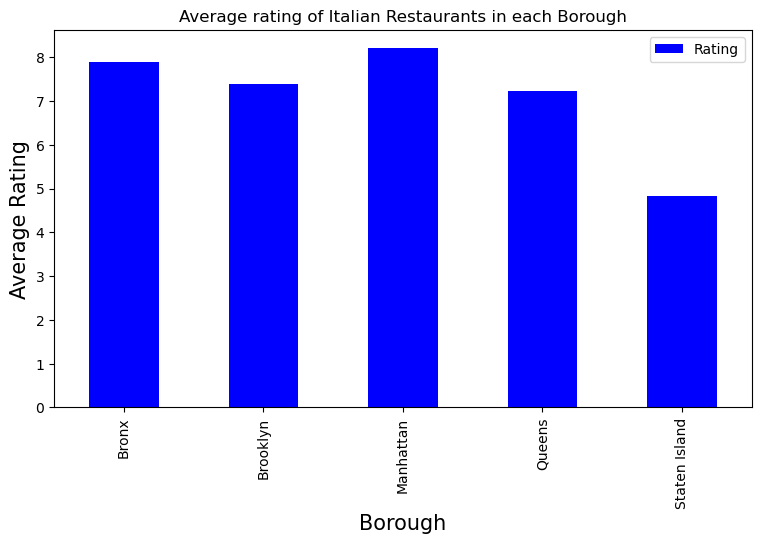

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Italian Restaurants in each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [33]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Auburndale,8.000000
4,Battery Park City,8.000000
9,Bedford Stuyvesant,8.900000
11,Belmont,8.029412
13,Boerum Hill,9.100000
15,Bushwick,9.300000
19,Chinatown,8.200000
20,City Island,8.200000
23,Clinton Hill,8.650000
24,Cobble Hill,8.533333


Now we join the above data to the original New York data to get the latitude and longitude.

In [34]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,8.000000
1,Manhattan,Battery Park City,40.711932,-74.016869,8.000000
2,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.900000
3,Bronx,Belmont,40.857277,-73.888452,8.029412
4,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
5,Brooklyn,Bushwick,40.698116,-73.925258,9.300000
6,Manhattan,Chinatown,40.715618,-73.994279,8.200000
7,Bronx,City Island,40.847247,-73.786488,8.200000
8,Brooklyn,Clinton Hill,40.693229,-73.967843,8.650000
9,Brooklyn,Cobble Hill,40.687920,-73.998561,8.533333


Now we will map this data. 

In [36]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [37]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
    
ny_map.add_child(rating)

# __<font size=6>Conclusion<font/>__

On average, Manhattan and Brooklyn have the best rated Italian restaurants of the five boroughs. Queens has by far the least amount of Italian restaurants of any borough with just over 20. For reference, Manhattan has nearly 100. Given the high average rating and competition in Manhattan, we can rule out Manhattan as the best place for opening a new Italian restaurant. Based on all of the info, I think opening a new Italian restaurant in Queens is the best move. Queens has the 2nd lowest average rating of any of the five boroughs while also having the least amount of Italian restaurants. This presents the unique opportunity of less competition and a lower bar to clear to be the best Italian restaurant in the borough whereas the competitive landscape in the Bronx or Manhattan would be much more difficult. All of this analysis is reliant on data from Foursquare. 